In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import requests
import json
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import psycopg2
from config import config
import gspread
from gspread_dataframe import set_with_dataframe
from google.oauth2.service_account import Credentials
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
import scipy

# Import Data

In [2]:
param_database = config('postgresql')

In [3]:
def init_connection():
    conn = psycopg2.connect(**param_database)
    cur = conn.cursor()
    return conn, cur

In [4]:
def query_to_df(conn,cur,query) -> pd.DataFrame:
    cur.execute(query)
    tuples_list = cur.fetchall()
    colnames = [desc[0] for desc in cur.description]
    df = pd.DataFrame(tuples_list,columns=colnames)
    return df

In [5]:
conn, cur = init_connection()

In [6]:
btc_daily = query_to_df(conn,cur,"""
    SELECT * FROM btc_daily;
    """)

In [7]:
btc_monthly = query_to_df(conn,cur,"""
    SELECT * FROM btc_monthly;
    """)

In [8]:
cpi_monthly = query_to_df(conn,cur,"""
    SELECT * FROM cpi_monthly;
    """)

In [9]:
gold_daily = query_to_df(conn,cur,"""
    SELECT * FROM gold_daily;
    """)

In [10]:
gold_monthly = query_to_df(conn,cur,"""
    SELECT * FROM gold_monthly;
    """)

In [11]:
ihsg_daily = query_to_df(conn,cur,"""
    SELECT * FROM ihsg_daily;
    """)

In [12]:
ihsg_monthly = query_to_df(conn,cur,"""
    SELECT * FROM ihsg_monthly;
    """)

In [13]:
usd_daily = query_to_df(conn,cur,"""
    SELECT * FROM usd_daily;
    """)

In [14]:
usd_monthly = query_to_df(conn,cur,"""
    SELECT * FROM usd_monthly;
    """)

In [15]:
monthly_changes = query_to_df(conn,cur,"""
    SELECT
        monthdate,
        cast(cpi_mom_change as decimal) cpi_mom_change,
        cast(btc_mom_change as decimal) btc_mom_change,
        ihsg_mom_change,
        usd_mom_change,
        cast(gold_mom_change as decimal) gold_mom_change
    FROM monthly_changes;
    """)

In [16]:
combined_monthly = query_to_df(conn,cur,"""
    select 
        c.cpi,
        b.avg_closing as btc,
        u.avg_closing as usd,
        i.avg_closing as ihsg,
        g.avg_closing as gold
    from cpi_monthly c
    left join btc_monthly b
    on c.monthdate = b.monthdate
    left join usd_monthly u
    on c.monthdate = u.monthdate
    left join ihsg_monthly i
    on c.monthdate = i.monthdate
    left join gold_monthly g
    on c.monthdate = g.monthdate; 
    """)

In [17]:
yearly_changes = query_to_df(conn,cur,"""
    SELECT * FROM yearly_changes;
    """)

In [18]:
cur.close()
conn.close()

# Export Dataframes to Google Sheets

In [18]:
df_dict = {
    'btc_daily':btc_daily,
    'btc_monthly':btc_monthly,
    'cpi_monthly':cpi_monthly,
    'gold_daily':gold_daily,
    'gold_monthly':gold_monthly,
    'ihsg_daily':ihsg_daily,
    'ihsg_monthly':ihsg_monthly,
    'usd_daily':usd_daily,
    'usd_monthly':usd_monthly,
    'monthly_changes':monthly_changes,
    'yearly_changes':yearly_changes
}

In [19]:
scopes = ['https://www.googleapis.com/auth/spreadsheets',
          'https://www.googleapis.com/auth/drive']

credentials = Credentials.from_service_account_file('four-assets-project-b8195ded184f.json', scopes=scopes)

gc = gspread.authorize(credentials)

# gauth = GoogleAuth()
# drive = GoogleDrive(gauth)

# open a google sheet
gs = gc.open_by_key('1-_CTf0vEsV-FQTJVVsqSVFykAls0_0ZND9redN8qIS0')
# select a work sheet from its name
worksheet1 = gs.worksheet('btc_daily')

In [20]:
def export_to_gsheet(sheet_name,dataframe):
    ws = gs.worksheet(sheet_name)
    ws.clear()
    set_with_dataframe(worksheet=ws,dataframe=dataframe,include_index=False,include_column_header=True,resize=True)
    print(f'Finished exporting {sheet_name} to gsheet')

In [21]:
for name,df in df_dict.items():
    export_to_gsheet(name,df)

Finished exporting btc_daily to gsheet
Finished exporting btc_monthly to gsheet
Finished exporting cpi_monthly to gsheet
Finished exporting gold_daily to gsheet
Finished exporting gold_monthly to gsheet
Finished exporting ihsg_daily to gsheet
Finished exporting ihsg_monthly to gsheet
Finished exporting usd_daily to gsheet
Finished exporting usd_monthly to gsheet
Finished exporting monthly_changes to gsheet


In [22]:
worksheet_list = gs.worksheets()

# EDA & Viz

## Linechart

In [19]:
df_list = [btc_daily,btc_monthly,cpi_monthly,gold_daily,gold_monthly,ihsg_daily,ihsg_monthly,usd_daily,usd_monthly,monthly_changes]

In [20]:
for df in df_list:
    print(df.describe())

            closing       opening          high           low
count  2.392000e+03  2.392000e+03  2.392000e+03  2.392000e+03
mean   3.271471e+08  3.266895e+08  3.328071e+08  3.206519e+08
std    2.516926e+08  2.511786e+08  2.556571e+08  2.467226e+08
min    4.050600e+07  4.050610e+07  4.785000e+07  3.730020e+07
25%    1.163758e+08  1.162978e+08  1.185132e+08  1.134995e+08
50%    2.603650e+08  2.603655e+08  2.635325e+08  2.580000e+08
75%    4.930535e+08  4.930535e+08  5.015930e+08  4.825517e+08
max    1.144797e+09  1.144798e+09  1.149990e+09  1.113600e+09
         monthdate            avg_closing
count           79                     79
unique          79                     79
top     2018-11-01  80102200.000000000000
freq             1                      1
              cpi
count  100.000000
mean   103.846700
std      6.760906
min     92.060000
25%     98.847500
50%    104.670000
75%    107.202500
max    116.560000
            closing       opening          high           low
count  1

In [27]:
color_dict = {
    'CPI':'rgb(111,64,112)',
    'Bitcoin':'rgb(204,80,62)',
    'IHSG':'rgb(29,105,150)',
    'USD':'rgb(115,175,72)',
    'Gold':'rgb(237,173,8)'
}

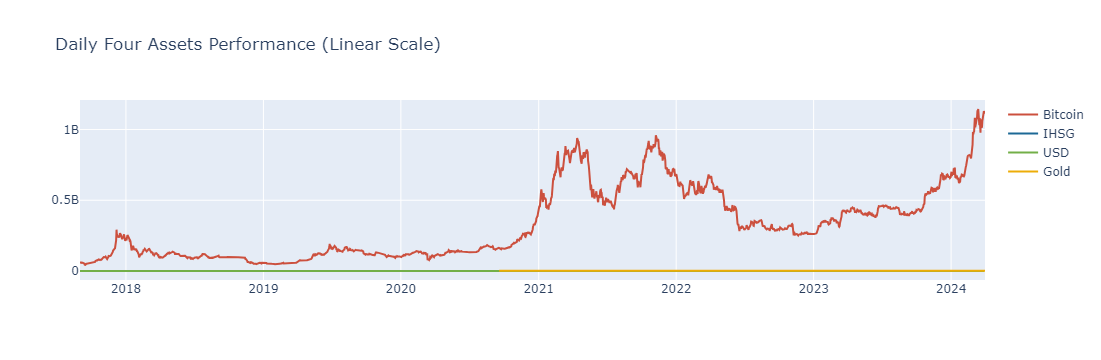

In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=btc_daily['date'],y=btc_daily['closing'],mode='lines',name='Bitcoin',line={'color':color_dict['Bitcoin']}))
fig.add_trace(go.Scatter(x=ihsg_daily['date'],y=ihsg_daily['closing'],mode='lines',name='IHSG',line={'color':color_dict['IHSG']}))
fig.add_trace(go.Scatter(x=usd_daily['date'],y=usd_daily['closing'],mode='lines',name='USD',line={'color':color_dict['USD']}))
fig.add_trace(go.Scatter(x=gold_daily['date'],y=gold_daily['closing'],mode='lines',name='Gold',line={'color':color_dict['Gold']}))

fig.update_layout(title='Daily Four Assets Performance (Linear Scale)')
fig.show()

As can be seen, Bitcoin prices are significantly higher, resulting in other assets looking non significant, hence we are going to rescale using logarithmic scale.

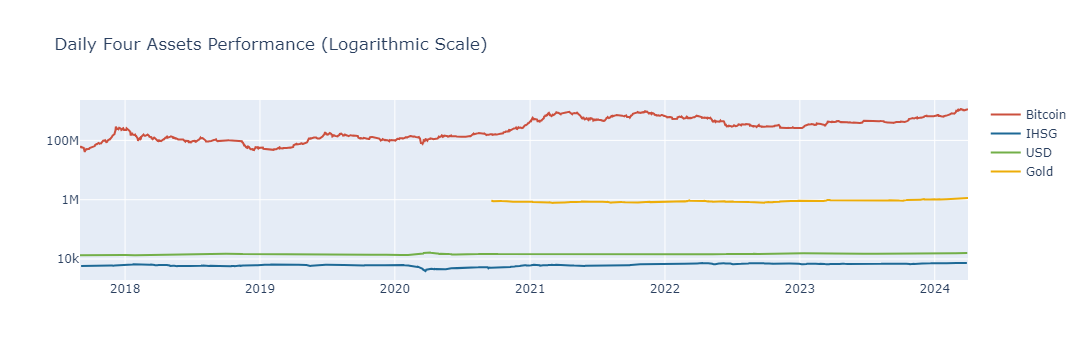

In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=btc_daily['date'],y=btc_daily['closing'],mode='lines',name='Bitcoin',line={'color':color_dict['Bitcoin']}))
fig.add_trace(go.Scatter(x=ihsg_daily['date'],y=ihsg_daily['closing'],mode='lines',name='IHSG',line={'color':color_dict['IHSG']}))
fig.add_trace(go.Scatter(x=usd_daily['date'],y=usd_daily['closing'],mode='lines',name='USD',line={'color':color_dict['USD']}))
fig.add_trace(go.Scatter(x=gold_daily['date'],y=gold_daily['closing'],mode='lines',name='Gold',line={'color':color_dict['Gold']}))

fig.update_yaxes(type='log')
fig.update_layout(title='Daily Four Assets Performance (Logarithmic Scale)')
fig.show()

## Correlation Coefficient

In [24]:
combined_monthly.head()

cpi                    btc           usd         ihsg  \
0  109.98     597520998.40000000  14373.052632  7198.951053   
1  100.56  80102200.000000000000  14657.636364  5950.356190   
2   98.11     230653478.70967742  13559.000000  6121.167222   
3  101.54  56513290.322580645161  14204.071429  6450.893000   
4  106.29     853331931.73333333  14523.809524  6012.274286   

                  gold  
0  896046.360000000000  
1                 None  
2                 None  
3                 None  
4  821723.538461538462

In [25]:
cr = combined_monthly.corr(method='pearson')

In [26]:
cr

cpi       btc       usd      ihsg      gold
cpi   1.000000  0.496564  0.692699  0.523967  0.374234
btc   0.496564  1.000000  0.328604  0.479199  0.105996
usd   0.692699  0.328604  1.000000  0.291770  0.735713
ihsg  0.523967  0.479199  0.291770  1.000000  0.440105
gold  0.374234  0.105996  0.735713  0.440105  1.000000

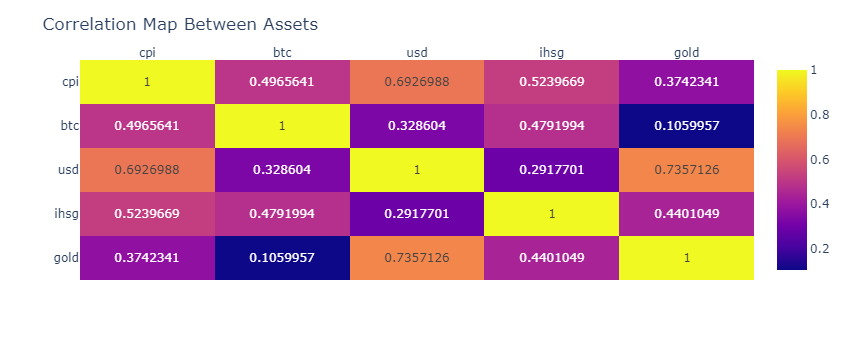

In [27]:
cr = combined_monthly.corr(method='pearson')
fig = px.imshow(cr,text_auto=True,aspect='auto')

fig.update_layout(title='Correlation Map Between Assets')
fig.update_xaxes(side="top")
fig.show()

## Change Data Column Type

In [20]:
monthly_changes.head()

monthdate        cpi_mom_change           btc_mom_change  ihsg_mom_change  \
0  2017-09-01   0.00133910177173457                     None              NaN   
1  2017-10-01  0.000102870075095129       0.3308502867420972         0.012987   
2  2017-11-01    0.0019543303846945       0.4921242033080992         0.016285   
3  2017-12-01   0.00718612052150713       1.1497879944547865         0.013747   
4  2018-01-01     0.006217510957089  -0.18071583723475906519         0.056185   

   usd_mom_change gold_mom_change  
0             NaN            None  
1        0.016551            None  
2       -0.000018            None  
3        0.002325            None  
4       -0.012655            None

In [21]:
monthly_changes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   monthdate        100 non-null    object 
 1   cpi_mom_change   99 non-null     object 
 2   btc_mom_change   78 non-null     object 
 3   ihsg_mom_change  78 non-null     float64
 4   usd_mom_change   78 non-null     float64
 5   gold_mom_change  42 non-null     object 
dtypes: float64(2), object(4)
memory usage: 4.8+ KB


In [22]:
def change_column_to_float(dataframe,columns):
    for col in columns:
        dataframe[col].fillna(value=np.nan,inplace=True)
        dataframe[col] = dataframe[col].astype('float')
        print(f'Column {col} type have been changed')

In [23]:
# Change columns with object data type to float
object_cols = ['cpi_mom_change','btc_mom_change','gold_mom_change']
change_column_to_float(monthly_changes,object_cols)

# for col in object_cols:
#     monthly_changes[col].fillna(value=np.nan,inplace=True)
#     monthly_changes[col] = monthly_changes[col].astype('float')

Column cpi_mom_change type have been changed
Column btc_mom_change type have been changed
Column gold_mom_change type have been changed


In [24]:
yearly_changes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   yeardate         9 non-null      object 
 1   cpi_yoy_change   8 non-null      float64
 2   btc_yoy_change   7 non-null      object 
 3   usd_yoy_change   7 non-null      float64
 4   ihsg_yoy_change  7 non-null      float64
 5   gold_yoy_change  4 non-null      object 
dtypes: float64(3), object(3)
memory usage: 564.0+ bytes


In [25]:
# Change columns with object data type to float
object_cols = ['btc_yoy_change','gold_yoy_change']
change_column_to_float(yearly_changes,object_cols)

Column btc_yoy_change type have been changed
Column gold_yoy_change type have been changed


In [26]:
monthly_changes.head()

monthdate  cpi_mom_change  btc_mom_change  ihsg_mom_change  \
0  2017-09-01        0.001339             NaN              NaN   
1  2017-10-01        0.000103        0.330850         0.012987   
2  2017-11-01        0.001954        0.492124         0.016285   
3  2017-12-01        0.007186        1.149788         0.013747   
4  2018-01-01        0.006218       -0.180716         0.056185   

   usd_mom_change  gold_mom_change  
0             NaN              NaN  
1        0.016551              NaN  
2       -0.000018              NaN  
3        0.002325              NaN  
4       -0.012655              NaN

## Monthly Changes

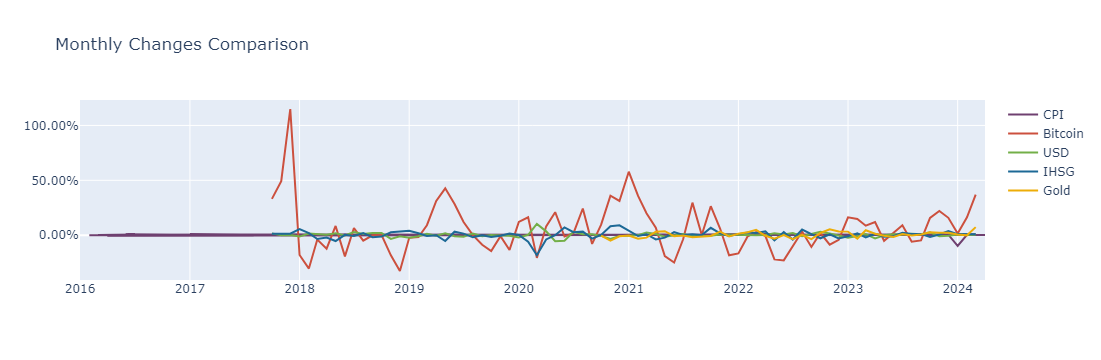

In [33]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=monthly_changes['monthdate'],y=monthly_changes['cpi_mom_change'],mode='lines',name='CPI',line={'color':color_dict['CPI']}))
fig.add_trace(go.Scatter(x=monthly_changes['monthdate'],y=monthly_changes['btc_mom_change'],mode='lines',name='Bitcoin',line={'color':color_dict['Bitcoin']}))
fig.add_trace(go.Scatter(x=monthly_changes['monthdate'],y=monthly_changes['usd_mom_change'],mode='lines',name='USD',line={'color':color_dict['USD']}))
fig.add_trace(go.Scatter(x=monthly_changes['monthdate'],y=monthly_changes['ihsg_mom_change'],mode='lines',name='IHSG',line={'color':color_dict['IHSG']}))
fig.add_trace(go.Scatter(x=monthly_changes['monthdate'],y=monthly_changes['gold_mom_change'],mode='lines',name='Gold',line={'color':color_dict['Gold']}))

fig.update_layout(title='Monthly Changes Comparison')
fig.update_yaxes(tickformat=".2%")
fig.show()

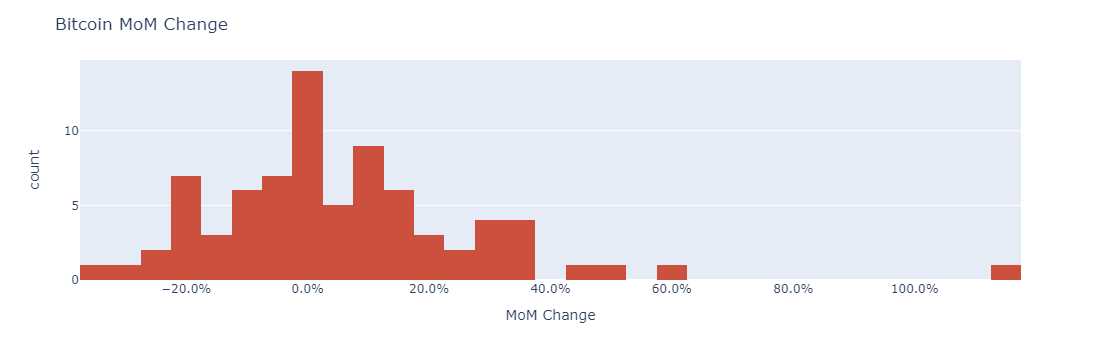

In [39]:
fig = px.histogram(monthly_changes,x='btc_mom_change',nbins=30,color_discrete_sequence=[color_dict['Bitcoin']])

fig.update_layout(title='Bitcoin MoM Change')
fig.update_xaxes(tickformat=".1%",title='MoM Change')
fig.show()

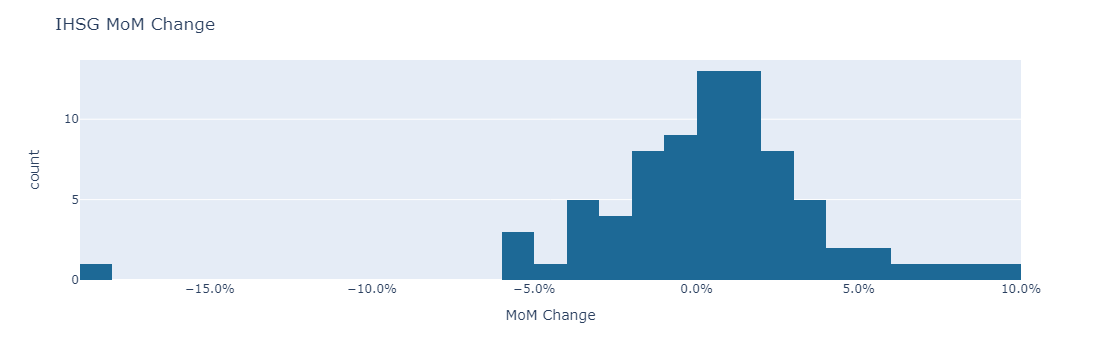

In [40]:
fig = px.histogram(monthly_changes,x='ihsg_mom_change',nbins=30,color_discrete_sequence=[color_dict['IHSG']])

fig.update_layout(title='IHSG MoM Change')
fig.update_xaxes(tickformat=".1%",title='MoM Change')
fig.show()

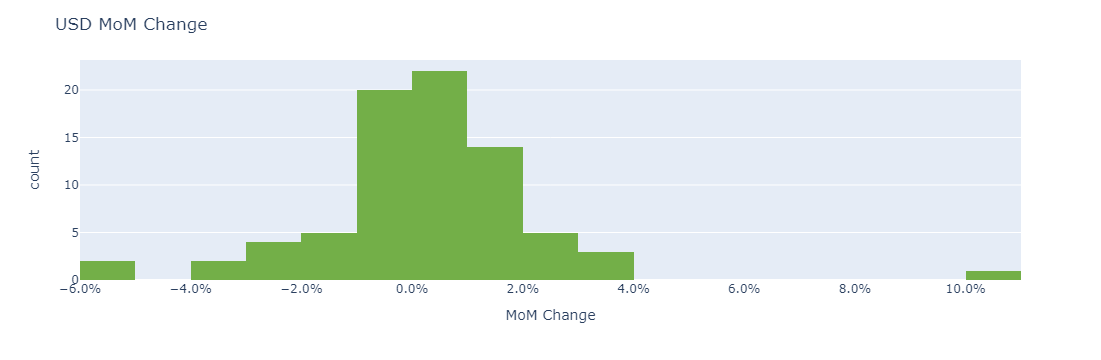

In [41]:
fig = px.histogram(monthly_changes,x='usd_mom_change',nbins=30,color_discrete_sequence=[color_dict['USD']])

fig.update_layout(title='USD MoM Change')
fig.update_xaxes(tickformat=".1%",title='MoM Change')
fig.show()

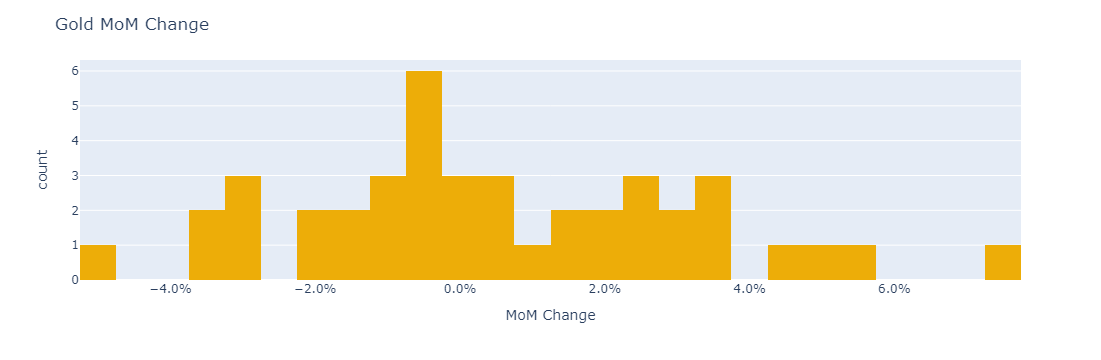

In [42]:
fig = px.histogram(monthly_changes,x='gold_mom_change',nbins=30,color_discrete_sequence=[color_dict['Gold']])

fig.update_layout(title='Gold MoM Change')
fig.update_xaxes(tickformat=".1%",title='MoM Change')
fig.show()

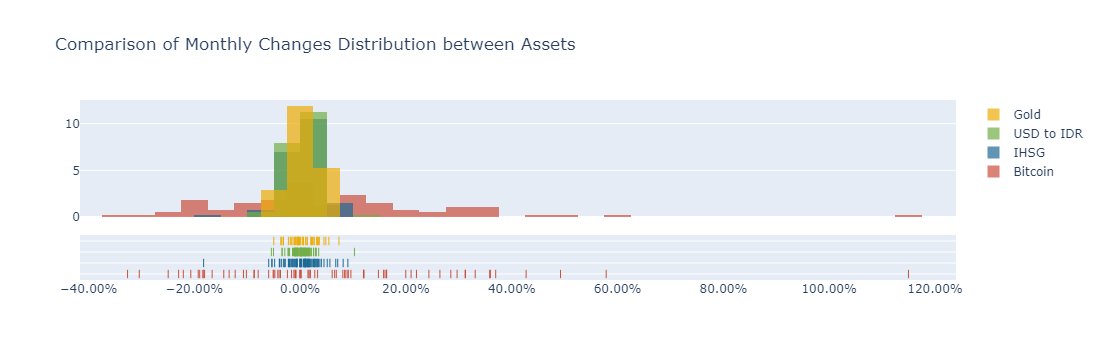

In [43]:
mc_array = [monthly_changes[col].values for col in monthly_changes.columns[2:]]
col_names = ['Bitcoin','IHSG','USD to IDR','Gold']

fig = ff.create_distplot(mc_array,group_labels=col_names,show_curve=False,
                         colors=list(color_dict.values())[1:],bin_size=0.05)

fig.update_layout(title='Monthly Changes Distribution between Assets (Histograms)')
fig.update_xaxes(tickformat=".2%")
fig.show()

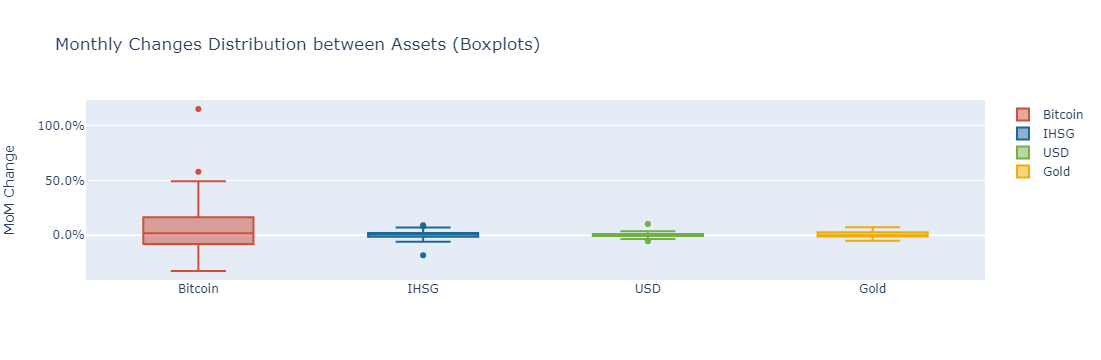

In [37]:
mc = monthly_changes.dropna()
mc_array = [monthly_changes[col].values for col in monthly_changes.columns[2:]]
col_names = ['Bitcoin','IHSG','USD','Gold']

fig = go.Figure()
for val,name in zip(mc_array,col_names):
    fig.add_trace(go.Box(y=val, name=name, marker_color=color_dict[name]))

fig.update_layout(title='Monthly Changes Distribution between Assets (Boxplots)')
fig.update_yaxes(tickformat=".1%",title='MoM Change')

fig.show()

## Monthly Changes Correlation

In [36]:
mc = monthly_changes.drop(columns=['monthdate'])
cr = mc.corr(method='pearson')
cr

cpi_mom_change  btc_mom_change  ihsg_mom_change  \
cpi_mom_change         1.000000        0.040320         0.000406   
btc_mom_change         0.040320        1.000000         0.185016   
ihsg_mom_change        0.000406        0.185016         1.000000   
usd_mom_change        -0.055713       -0.133187        -0.643977   
gold_mom_change       -0.008588       -0.021640        -0.181108   

                 usd_mom_change  gold_mom_change  
cpi_mom_change        -0.055713        -0.008588  
btc_mom_change        -0.133187        -0.021640  
ihsg_mom_change       -0.643977        -0.181108  
usd_mom_change         1.000000         0.063435  
gold_mom_change        0.063435         1.000000

## Yearly Changes

In [44]:
yearly_changes.head()

yeardate  cpi_yoy_change  btc_yoy_change  usd_yoy_change  \
0  2017-01-01        0.038086             NaN             NaN   
1  2018-01-01        0.032002       -0.066710        0.055774   
2  2019-01-01        0.030308       -0.032243       -0.006476   
3  2020-01-01        0.020178        0.531773        0.026331   
4  2021-01-01        0.015601        3.250876       -0.015340   

   ihsg_yoy_change  gold_yoy_change  
0              NaN              NaN  
1         0.016190              NaN  
2         0.034394              NaN  
3        -0.166337              NaN  
4         0.186715        -0.049721

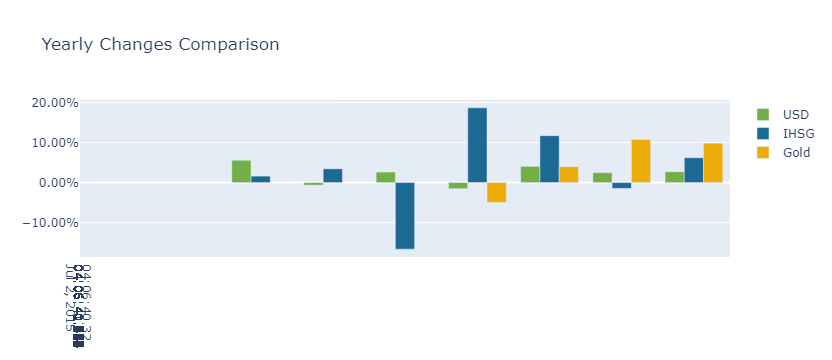

In [61]:
fig = go.Figure()
# fig.add_trace(go.Bar(x=yearly_changes['yeardate'],y=yearly_changes['btc_yoy_change'],name='Bitcoin',marker_color=color_dict['Bitcoin']))
fig.add_trace(go.Bar(x=yearly_changes['yeardate'],y=yearly_changes['usd_yoy_change'],name='USD',marker_color=color_dict['USD']))
fig.add_trace(go.Bar(x=yearly_changes['yeardate'],y=yearly_changes['ihsg_yoy_change'],name='IHSG',marker_color=color_dict['IHSG']))
fig.add_trace(go.Bar(x=yearly_changes['yeardate'],y=yearly_changes['gold_yoy_change'],name='Gold',marker_color=color_dict['Gold']))

fig.update_layout(title='Yearly Changes Comparison')
fig.update_yaxes(tickformat=".2%")
fig.update_xaxes(dtick=1)
fig.show()

# Descriptive Stats

In [37]:
mc.head()

cpi_mom_change  btc_mom_change  ihsg_mom_change  usd_mom_change  \
0        0.001339             NaN              NaN             NaN   
1        0.000103        0.330850         0.012987        0.016551   
2        0.001954        0.492124         0.016285       -0.000018   
3        0.007186        1.149788         0.013747        0.002325   
4        0.006218       -0.180716         0.056185       -0.012655   

   gold_mom_change  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

In [43]:
asset_mc = mc.iloc[:,1:]

In [49]:
asset_mc.describe().round(4)

btc_mom_change  ihsg_mom_change  usd_mom_change  gold_mom_change
count         78.0000          78.0000         78.0000          42.0000
mean           0.0599           0.0036          0.0023           0.0050
std            0.2253           0.0366          0.0202           0.0272
min           -0.3263          -0.1825         -0.0545          -0.0500
25%           -0.0745          -0.0136         -0.0076          -0.0107
50%            0.0175           0.0081          0.0021          -0.0003
75%            0.1613           0.0206          0.0116           0.0252
max            1.1498           0.0901          0.1026           0.0733

In [71]:
summary = pd.DataFrame()
summary['Average Return'] = asset_mc.mean(axis=0)
summary['Volatility'] = asset_mc.std(axis=0)
summary['Sharpe Ratio'] = summary['Average Return']/summary['Volatility']
summary

Average Return  Volatility  Sharpe Ratio
btc_mom_change         0.059872    0.225282      0.265766
ihsg_mom_change        0.003566    0.036629      0.097356
usd_mom_change         0.002319    0.020222      0.114657
gold_mom_change        0.004971    0.027235      0.182525

## Choosing The Weights of the Assets

code source: https://www.datacamp.com/workspace/external-link?url=https%3A%2F%2Ftowardsdatascience.com%2Fefficient-frontier-in-python-detailed-tutorial-84a304f03e79

In [55]:
annual_r = (1+asset_mc.mean())**12-1
cov = asset_mc.cov()*12
n_assets = 4

return_variance_pairs = []

weights_list = [] # to store weights
assets_list = [] # to store asset names

for i in range(10000): # simulate 10.000 portfolios
    next_i = False
    while True:
        assets = list(asset_mc.columns)
        weights = np.random.rand(n_assets) # choose weights randomly
        weights = weights/sum(weights)

        # Loop over asset paris and compute portfolio return and variance
        portfolio_exp_variance = 0
        portfolio_exp_return = 0
        for j in range(len(assets)):
            portfolio_exp_return += weights[j] * annual_r.loc[assets[j]]
            for k in range(len(assets)):
                portfolio_exp_variance += weights[j] * weights[k] * cov.loc[assets[j],assets[k]]

        # If a portfolio is suboptimal (we found one with same risk but higher exp return, skip
        for R,V in return_variance_pairs:
            if (R > portfolio_exp_return) & (V < portfolio_exp_variance):
                next_i = True
                break
            if next_i:
                break

        # save mean variance pairs and weights
        return_variance_pairs.append([portfolio_exp_return,portfolio_exp_variance])
        weights_list.append(weights)
        assets_list.append(assets)
        break

In [101]:
return_variance_pairs[:,1]**0.5

array([[0.31975061, 0.05196642],
       [0.09071053, 0.00948979],
       [0.18844686, 0.01547282],
       ...,
       [0.38783767, 0.0824959 ],
       [0.38301683, 0.07440771],
       [0.31487056, 0.04952359]])

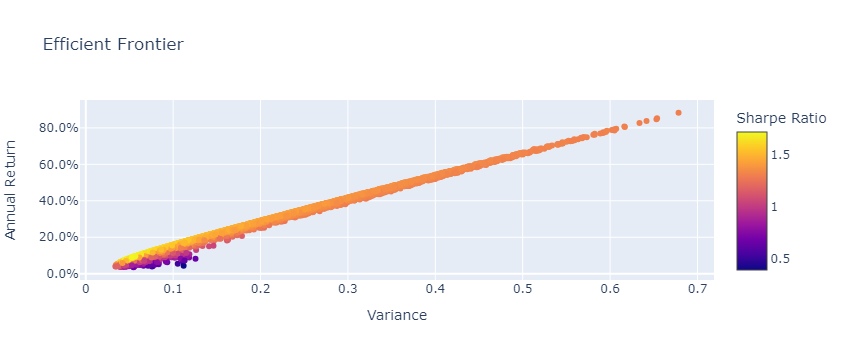

In [72]:
return_variance_pairs = np.array(return_variance_pairs)

fig = go.Figure()
fig.add_trace(go.Scatter(x=return_variance_pairs[:,1]**0.5,y=return_variance_pairs[:,0],mode='markers'
                         ,marker=dict(color=return_variance_pairs[:,0]/(return_variance_pairs[:,1]**0.5)
                          ,showscale=True,colorbar=dict(title='Sharpe Ratio'))))

fig.update_layout(title='Efficient Frontier')
fig.update_xaxes(title='Volatility',tickformat=".1%")
fig.update_yaxes(title='Annual Return',tickformat=".1%")

annotation_minvar = {

In [108]:
return_variance_df = pd.DataFrame(return_variance_pairs,columns=['Annual Return','Variance'])
return_variance_df['Sharpe Ratio'] = return_variance_df['Annual Return']/(return_variance_df['Variance']**0.5)
weights_df = pd.DataFrame(weights_list,columns=['Bitcoin','IHSG','USD','Gold'])
combination_df = return_variance_df.join(weights_df)

In [109]:
min_volatility = combination_df.iloc[combination_df['Variance'].idxmin()]
min_volatility

Annual Return    0.039498
Variance         0.001153
Sharpe Ratio     1.163326
Bitcoin          0.002863
IHSG             0.296865
USD              0.582003
Gold             0.118269
Name: 7110, dtype: float64

In [110]:
max_sharpe = combination_df.iloc[combination_df['Sharpe Ratio'].idxmax()]
max_sharpe

Annual Return    0.089139
Variance         0.002688
Sharpe Ratio     1.719277
Bitcoin          0.050265
IHSG             0.229958
USD              0.475680
Gold             0.244097
Name: 7731, dtype: float64

In [111]:
max_return = combination_df.iloc[combination_df['Annual Return'].idxmax()]
max_return

Annual Return    0.882980
Variance         0.460177
Sharpe Ratio     1.301632
Bitcoin          0.868310
IHSG             0.042940
USD              0.021469
Gold             0.067281
Name: 1173, dtype: float64

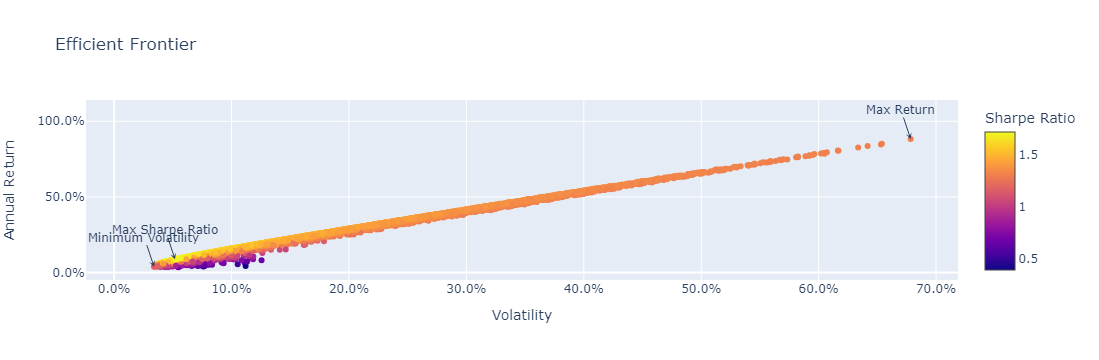

In [120]:
return_variance_pairs = np.array(return_variance_pairs)
annotation_minvol = {'x':min_volatility['Variance']**0.5,'y':min_volatility['Annual Return'],'showarrow':True,'arrowhead':3
                     ,'text':'Minimum Volatility'}
annotation_maxsharpe = {'x':max_sharpe['Variance']**0.5,'y':max_sharpe['Annual Return'],'showarrow':True,'arrowhead':3
                     ,'text':'Max Sharpe Ratio'}
annotation_maxret = {'x':max_return['Variance']**0.5,'y':max_return['Annual Return'],'showarrow':True,'arrowhead':3
                     ,'text':'Max Return'}

fig = go.Figure()
fig.add_trace(go.Scatter(x=return_variance_pairs[:,1]**0.5,y=return_variance_pairs[:,0],mode='markers'
                         ,marker=dict(color=return_variance_pairs[:,0]/(return_variance_pairs[:,1]**0.5)
                          ,showscale=True,colorbar=dict(title='Sharpe Ratio'))))

fig.update_layout(dict(annotations=[annotation_minvol,annotation_maxsharpe,annotation_maxret]),title='Efficient Frontier')
fig.update_xaxes(title='Volatility',tickformat=".1%")
fig.update_yaxes(title='Annual Return',tickformat=".1%")